# Face alignment on FPD
In this notebook, opencv is employed to realize face alignment of some selected images in FPD dataset.

In [1]:
import torch
import torch.nn as nn
import torch.optim as opt
import torchvision
from torchvision import transforms
import torch.utils.data as data
from torch.utils.data import DataLoader
import torchvision.transforms.functional as tf
from PIL import Image
import os.path as osp
import numpy as np
from numpy.random import uniform
import PIL
from PIL import Image, ImageDraw
from random import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math
import random
import argparse
import os
import copy
import json
import cv2
import warnings
warnings.filterwarnings("ignore")

## models and functions for detection

In [2]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.constant_(m.bias, 0.1)
        

class P_Net(nn.Module):
    def __init__(self):
        super(P_Net, self).__init__()
        self.pre_layer = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=3, stride=1),
            nn.PReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Conv2d(10, 16, kernel_size=3, stride=1),
            nn.PReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1),
            nn.PReLU()
        )
        self.conv4_1 = nn.Conv2d(32, 1, kernel_size=1, stride=1)
        self.conv4_2 = nn.Conv2d(32, 4, kernel_size=1, stride=1)
        self.conv4_3 = nn.Conv2d(32, 10, kernel_size=1, stride=1)
        self.apply(weights_init)

    def forward(self, x):
        x = self.pre_layer(x)
        det = torch.sigmoid(self.conv4_1(x))
        box = self.conv4_2(x)
        landmark = self.conv4_3(x)
        return det, box, landmark
    
    
    
class R_Net(nn.Module):
    def __init__(self):
        super(R_Net, self).__init__()
        self.pre_layer = nn.Sequential(
            nn.Conv2d(3, 28, kernel_size=3, stride=1),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(28, 48, kernel_size=3, stride=1),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(48, 64, kernel_size=2, stride=1),
            nn.PReLU()
        )
        self.conv4 = nn.Linear(64 * 2 * 2, 128)
        self.prelu4 = nn.PReLU()
        self.conv5_1 = nn.Linear(128, 1)
        self.conv5_2 = nn.Linear(128, 4)
        self.conv5_3 = nn.Linear(128, 10)
        self.apply(weights_init)

    def forward(self, x):
        x = self.pre_layer(x)
        x = x.view(x.size(0), -1)
        x = self.conv4(x)
        x = self.prelu4(x)
        det = torch.sigmoid(self.conv5_1(x))
        box = self.conv5_2(x)
        landmark = self.conv5_3(x)
        return det, box, landmark

    
    
class O_Net(nn.Module):
    def __init__(self):
        super(O_Net, self).__init__()
        self.pre_layer = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=2, stride=1),
            nn.PReLU()
        )
        self.conv5 = nn.Linear(128 * 2 * 2, 256)
        self.prelu5 = nn.PReLU()
        self.conv6_1 = nn.Linear(256, 1)
        self.conv6_2 = nn.Linear(256, 4)
        self.conv6_3 = nn.Linear(256, 10)
        self.apply(weights_init)

    def forward(self, x):
        x = self.pre_layer(x)
        x = x.view(x.size(0), -1)
        x = self.conv5(x)
        x = self.prelu5(x)
        det = torch.sigmoid(self.conv6_1(x))
        box = self.conv6_2(x)
        landmark = self.conv6_3(x)
        return det, box, landmark


In [3]:
global DEVICE
DEVICE = torch.device('cuda:0')
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')

In [4]:
def run_first_stage(image, net, scale, threshold):
    
    width, height = image.size
    sw, sh = math.ceil(width * scale), math.ceil(height * scale)
    img = image.resize((sw, sh), Image.BILINEAR)
    img = transforms.ToTensor()(img).unsqueeze(0)
    img = img.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

    output = net(img)
    probs = output[0].data.cpu().numpy()[0, 0, :, :]
    offsets = output[1].data.cpu().numpy()
    boxes = _generate_bboxes(probs, offsets, scale, threshold)
    if len(boxes) == 0:
        return None

    keep = nms(boxes[:, 0:5], overlap_threshold=0.5)
    return boxes[keep]


def _generate_bboxes(probs, offsets, scale, threshold):

    stride = 2
    cell_size = 12

    inds = np.where(probs > threshold)

    if inds[0].size == 0:
        return np.array([])

    tx1, ty1, tx2, ty2 = [offsets[0, i, inds[0], inds[1]] for i in range(4)]

    offsets = np.array([tx1, ty1, tx2, ty2])
    score = probs[inds[0], inds[1]]

    bounding_boxes = np.vstack([
        np.round((stride * inds[1] + 1.0) / scale),
        np.round((stride * inds[0] + 1.0) / scale),
        np.round((stride * inds[1] + 1.0 + cell_size) / scale),
        np.round((stride * inds[0] + 1.0 + cell_size) / scale),
        score, offsets
    ])

    return bounding_boxes.T

def nms(boxes, overlap_threshold=0.5, mode='union'):

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    scores = boxes[:, 4]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h

        if mode is 'min':
            ovr = inter / np.minimum(areas[i], areas[order[1:]])
        else:
            ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= overlap_threshold)[0]
        order = order[inds + 1]
    return keep

In [5]:
def convert_to_square(bboxes):

    square_bboxes = np.zeros_like(bboxes)
    x1, y1, x2, y2 = [bboxes[:, i] for i in range(4)]
    h = y2 - y1 + 1.0
    w = x2 - x1 + 1.0
    max_side = np.maximum(h, w)
    square_bboxes[:, 0] = x1 + w * 0.5 - max_side * 0.5
    square_bboxes[:, 1] = y1 + h * 0.5 - max_side * 0.5
    square_bboxes[:, 2] = square_bboxes[:, 0] + max_side - 1.0
    square_bboxes[:, 3] = square_bboxes[:, 1] + max_side - 1.0
    return square_bboxes


def calibrate_box(bboxes, offsets):

    x1, y1, x2, y2 = [bboxes[:, i] for i in range(4)]
    w = x2 - x1 + 1.0
    h = y2 - y1 + 1.0
    w = np.expand_dims(w, 1)
    h = np.expand_dims(h, 1)

    translation = np.hstack([w, h, w, h]) * offsets
    bboxes[:, 0:4] = bboxes[:, 0:4] + translation
    return bboxes


def get_image_boxes(bounding_boxes, img, size=24):
    
    num_boxes = len(bounding_boxes)
    width, height = img.size
    [dy, edy, dx, edx, y, ey, x, ex, w, h] = correct_bboxes(bounding_boxes, width, height)
    img_boxes = np.zeros((num_boxes, 3, size, size), 'float32')

    for i in range(num_boxes):
        img_box = np.zeros((h[i], w[i], 3), 'uint8')
        img_array = np.asarray(img, 'uint8')
        img_box[dy[i]:(edy[i] + 1), dx[i]:(edx[i] + 1), :] = \
            img_array[y[i]:(ey[i] + 1), x[i]:(ex[i] + 1), :]
        
        if img_box.shape[0]*img_box.shape[1]!=0:
            img_box = Image.fromarray(img_box)
            img_box = img_box.resize((size, size), Image.BILINEAR)
            img_box = np.asarray(img_box, 'float32')
            img_boxes[i, :, :, :] = img_normalization(img_box)

    return img_boxes


def correct_bboxes(bboxes, width, height):

    x1, y1, x2, y2 = [bboxes[:, i] for i in range(4)]
    w, h = x2 - x1 + 1.0, y2 - y1 + 1.0
    num_boxes = bboxes.shape[0]

    x, y, ex, ey = x1, y1, x2, y2
    dx, dy = np.zeros((num_boxes,)), np.zeros((num_boxes,))
    edx, edy = w.copy() - 1.0, h.copy() - 1.0

    ind = np.where(ex > width - 1.0)[0]
    edx[ind] = w[ind] + width - 2.0 - ex[ind]
    ex[ind] = width - 1.0

    ind = np.where(ey > height - 1.0)[0]
    edy[ind] = h[ind] + height - 2.0 - ey[ind]
    ey[ind] = height - 1.0

    ind = np.where(x < 0.0)[0]
    dx[ind] = 0.0 - x[ind]
    x[ind] = 0.0

    ind = np.where(y < 0.0)[0]
    dy[ind] = 0.0 - y[ind]
    y[ind] = 0.0
    return_list = [dy, edy, dx, edx, y, ey, x, ex, w, h]
    return_list = [i.astype('int32') for i in return_list]

    return return_list


def img_normalization(img):
    img = img.transpose((2, 0, 1))
    img = np.expand_dims(img, 0)
    img = (img - 127.5) * 0.0078125
    return img

In [6]:
THRESHOLDS = [0.85, 0.03, 0.3]
NMS_THRESHOLDS = [0.5, 0.9, 0.3]
MIN_FACE_SIZE = 15.0

def run_first_stage(image, net, scale, threshold):
    
    width, height = image.size
    sw, sh = math.ceil(width * scale), math.ceil(height * scale)
    img = image.resize((sw, sh), Image.BILINEAR)
    img = transforms.ToTensor()(img).unsqueeze(0)
    img = img.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

    output = net(img)
    probs = output[0].data.cpu().numpy()[0, 0, :, :]
    offsets = output[1].data.cpu().numpy()
    boxes = _generate_bboxes(probs, offsets, scale, threshold)
    if len(boxes) == 0:
        return None

    keep = nms(boxes[:, 0:5], overlap_threshold=0.5)
    return boxes[keep]


def pnet_boxes(img, pnet, min_face_size=MIN_FACE_SIZE, thresholds=THRESHOLDS, nms_thresholds=NMS_THRESHOLDS):
    pnet.eval()
    width, height = img.size
    min_length = min(height, width)
    min_detection_size = 12
    factor = 0.707
    scales = []
    m = min_detection_size / min_face_size
    min_length *= m
    factor_count = 0
    while min_length > min_detection_size:
        scales.append(m * factor ** factor_count)
        min_length *= factor
        factor_count += 1

    bounding_boxes = []
    for s in scales: 
        boxes = run_first_stage(img, pnet, scale=s, threshold=thresholds[0])
        bounding_boxes.append(boxes)
        
    bounding_boxes = [i for i in bounding_boxes if i is not None]

    try:
        _ = bounding_boxes[0]

    except Exception:
        pass
    if len(bounding_boxes) == 0:
        return None
    bounding_boxes = np.vstack(bounding_boxes)

    keep = nms(bounding_boxes[:, 0:5], nms_thresholds[0])
    bounding_boxes = bounding_boxes[keep]
    bounding_boxes = calibrate_box(bounding_boxes[:, 0:5], bounding_boxes[:, 5:])
    bounding_boxes = convert_to_square(bounding_boxes)
    bounding_boxes[:, 0:4] = np.round(bounding_boxes[:, 0:4])
    
    
    return bounding_boxes


def rnet_boxes(img, rnet, bounding_boxes, thresholds=THRESHOLDS, nms_thresholds=NMS_THRESHOLDS):
    rnet.eval()
    img_boxes = get_image_boxes(bounding_boxes, img, size=24)
    img_boxes = torch.FloatTensor(img_boxes)
    img_boxes = img_boxes.cuda()
    if img_boxes.size(0)==0:
        return []
    output = rnet(img_boxes)
    probs = output[0].data.cpu().numpy()
    offsets = output[1].data.cpu().numpy()

    keep = np.where(probs[:, 0] > thresholds[1])[0]
    bounding_boxes = bounding_boxes[keep]
    bounding_boxes[:, 4] = probs[keep, 0].reshape((-1,))
    offsets = offsets[keep]

    keep = nms(bounding_boxes, nms_thresholds[1])
    bounding_boxes = bounding_boxes[keep]
    bounding_boxes = calibrate_box(bounding_boxes, offsets[keep])
    bounding_boxes = convert_to_square(bounding_boxes)
    bounding_boxes[:, 0:4] = np.round(bounding_boxes[:, 0:4])
    return bounding_boxes


def onet_boxes(img, onet, bounding_boxes, thresholds=THRESHOLDS, nms_thresholds=NMS_THRESHOLDS):
    onet.eval()
    img_boxes = get_image_boxes(bounding_boxes, img, size=48)
    if len(img_boxes) == 0:
        return [], []
    img_boxes = torch.FloatTensor(img_boxes)
    img_boxes = img_boxes.cuda()
    
    output = onet(img_boxes)
    probs = output[0].data.cpu().numpy()
    offsets = output[1].data.cpu().numpy()
    landmarks = output[2].data.cpu().numpy()

    keep = np.where(probs[:, 0] > thresholds[2])[0]
    bounding_boxes = bounding_boxes[keep]

    bounding_boxes[:, 4] = probs[keep, 0].reshape((-1,))
    offsets = offsets[keep]
    landmarks = landmarks[keep]

    # compute landmark points
    
    width = bounding_boxes[:, 2] - bounding_boxes[:, 0] + 1.0
    height = bounding_boxes[:, 3] - bounding_boxes[:, 1] + 1.0
    xmin, ymin = bounding_boxes[:, 0], bounding_boxes[:, 1]

    landmarks[:, 0::2] = (np.expand_dims(xmin, 1) + np.expand_dims(width, 1) * landmarks[:, 0::2]).copy()
    landmarks[:, 1::2] = (np.expand_dims(ymin, 1) + np.expand_dims(height, 1) * landmarks[:, 1::2]).copy()

    bounding_boxes = calibrate_box(bounding_boxes, offsets)
    keep = nms(bounding_boxes, nms_thresholds[2], mode='union')
    bounding_boxes = bounding_boxes[keep]
    landmarks = landmarks[keep]
    return bounding_boxes, landmarks

Here are the models finalized for testing.

In [7]:
pnet=P_Net().cuda()
pnet.load_state_dict(torch.load('../input/mtcnn2/PNlm_1.pth'))
rnet=R_Net().cuda()
rnet.load_state_dict(torch.load('../input/mtcnn2/RNlm_1s.pth'))
onet=O_Net().cuda()
onet.load_state_dict(torch.load('../input/mtcnn2/ONlm_ag2.pth'))

<All keys matched successfully>

## load selected images in FPD

In [8]:
root = '../input/facial-point-detection/Facial_Point_Detection/'

def getlandmark():
    result = []
        
    file = open(root + 'trainImageList.txt')
    lines = file.readlines()
    
#     indexes = [270,275,289,409,522,624]
    indexes = [270,289,409,624]
    
    c = -1
    for line in lines:
        c += 1
        if c not in indexes:
            continue
        if c > indexes[-1]:
            break
        this_img = []
        line = line.strip()
        contents = line.split()
        name = contents[0]
        box = contents[1:5]
        landmark = contents[5:]
        image_full_path = root + name.replace('\\', '/')

        try:
            img = Image.open(image_full_path)
        except:
            print(image_full_path)
            continue
        result.append([image_full_path,[int(i) for i in box],[float(i) for i in landmark]])
        
    return result

## face alignment function

In [9]:
def face_alignment(img, boxes, landmarks, face_size=(224,224)):

    h, w = img.size
    output = []
    
    for i in range(len(landmarks)):
        box = boxes[i][:4]
        ldmk = landmarks[i]
        if len(ldmk) == 0:
            return []
        tan_angle = (ldmk[3]-ldmk[1])/(ldmk[2]-ldmk[0])
        eye_angle = np.degrees(np.arctan(tan_angle))
        M = cv2.getRotationMatrix2D((ldmk[4]/2, ldmk[5]/2), eye_angle, 1)
        aligned = cv2.warpAffine(np.array(img), M, (w, h))
        
        box_p = (np.append(box,[box[0],box[3],box[2],box[1]])).reshape(-1,2).T
        new_box_p = np.dot(M[:,:2],box_p) + M[:,2:3]

        x1 = min(new_box_p[0])
        y1 = min(new_box_p[1])
        x2 = max(new_box_p[0])
        y2 = max(new_box_p[1])      
        
        crop_img = aligned[int(y1):int(y2),int(x1):int(x2),:]
        output.append(crop_img)

    return output

## run

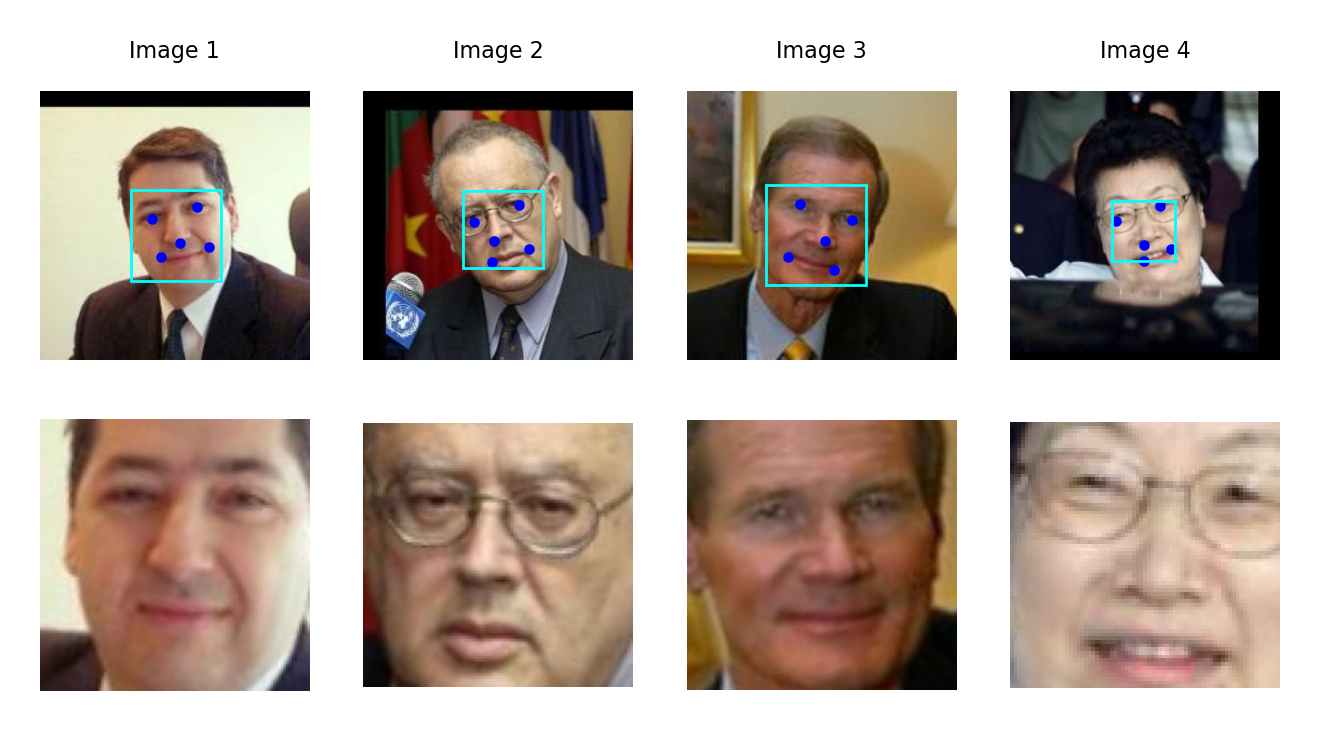

In [10]:
eval_demo = getlandmark()
num_demo = 4
fig, ax = plt.subplots(2,4,dpi = 400, figsize=(4,2))

for i in range(num_demo):
    img_pth, box, landmark = eval_demo[i]
    img = Image.open(img_pth)
    p_bounding_boxes = pnet_boxes(img, pnet)
    if p_bounding_boxes is None:
        print(i)
        continue
    ldmk = np.array(landmark).reshape(-1,2)
    r_bounding_boxes = rnet_boxes(img, rnet, p_bounding_boxes)
    o_bounding_boxes, pred_ldmk = onet_boxes(img, onet, r_bounding_boxes)
    aligned = face_alignment(img, o_bounding_boxes, pred_ldmk)
    
    ax[0,i].imshow(img)
    for b in o_bounding_boxes:
        ax[0,i].add_patch(plt.Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], fill=False, edgecolor='cyan',linewidth=0.5)) 
    for l in pred_ldmk:
        l = l.reshape(-1,2)
        ax[0,i].scatter(l[:,0],l[:,1], c='b',s=0.8)
    
    
    for n in range(len(aligned)):
        b = aligned[n]
        ax[1+n,i].imshow(b)
    

for axes in ax.ravel():
    axes.axis('off')
for i in range(4):
    ax[0,i].set_title('Image '+str(i+1),fontsize=4)
fig.show()
# fig.savefig('demo_test_good.png')